### Описание проекта

#### План работы

1. Проведите подготовительную работу (1 час):

    - Прочитайте предоставленный датасет.
    - Ознакомьтесь с описаниями представленных атрибутов.
    - Оцените полноту и чистоту данных. Попытайтесь понять, что стоит за этими данными в реальном мире. Приведите данные в удобный / нормальный вид для дальнейшей работы.
    
2. Проведите разведочный анализ данных (4 часа):

    - Проведите базовую чистку (дубликаты, пустые значения, типизация данных, ненужные атрибуты.

    - Посмотрите на распределение ключевых атрибутов, их отношения.

3. Выполните задание согласно вашей специализации (18 часов):

    - Научитесь предсказывать совершение целевого действия(ориентировочное значение ROC-AUC ~ 0.65) — факт совершения пользователей целевого действия.
    - Упакуйте получившуюся модель в сервис, который будет брать на вход все атрибуты, типа utm_*, device_*, geo_*, и отдавать на выход 0/1 (1 — если пользователь совершит любое целевое действие).

#### Глоссарий

Целевое действие — события типа «Оставить заявку» и «Заказать звонок»
(ga_hits.event_action in ['sub_car_claim_click', 'sub_car_claim_submit_click',
'sub_open_dialog_click', 'sub_custom_question_submit_click',
'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success',
'sub_car_request_submit_click']).

CR (Conversion Rate) — показатель конверсии из визита (уникальный
session_id) в любое целевое действие в рамках одного визита (в случае
наличия >1 целевого действия — считать все как одно).
Органический трафик — все визиты с ga_sessions.utm_medium in ('organic',
'referral', '(none)').

Платный трафик — весь неорганический трафик.
Информация про марку и модель авто — содержится
в ga_hits.hit_page_path.

Реклама в социальных сетях — все визиты с ga_sessions.utm_source in
('QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt', 'ISrKoXQCxqqYvAZICvjs',
IZEXUFLARCUMynmHNBGo', 'PlbkrSYoHuZBWfYjYnfw',
'gVRrcxiDQubJiljoTbGm').

#### Формат решения:
    
    - формат файла — (минимум) .py-скрипт с инструкцией по локальному запуску или (максимум) localhost web app.
    - Содержание — модель, берущая на вход строку с данными по визиту (согласно схеме данных) и отдающая на выход результат предсказания по отдельному событию в числовом формате 0|1.

#### Критерий оценки:
    
    - Значение ошибки на тестовой выборке (сравнение с бейслайном по идентичной метрике качества).

    - Подход к работе с фичами:
    
- Оценка проделанной работы с проработкой фичей: 

        - есть ли инжиниринг новых фичей? 
        - релевантны ли применяемые для инжиниринга методы?
        - насколько линейно зависимы итоговые фичи друг от друга?
            
- Насколько интерпретируемыми являются итоговые фичи в модели: 

        - можно ли описать их суть понятным языком для человека, которому нужно будет корректировать параметры рекламных кампаний?
            
- Насколько итоговые фичи значимы для результата с точки зрения
            оказываемого фичей вклада на итоговое значение предсказываемого
            целевого действия?

#### Описание данных

Данные из Google Analytics (last-click attribution model) по сайту
«СберАвтоподписка».

1 GA Sessions (ga_sessions.pkl)

Одна строка = один визит на сайт.

Описание атрибутов:

    ~ session_id — ID визита;
    ~ client_id — ID посетителя;
    ~ visit_date — дата визита;
    ~ visit_time — время визита;
    ~ visit_number — порядковый номер визита клиента;
    ~ utm_source — канал привлечения;
    ~ utm_medium — тип привлечения;
    ~ utm_campaign — рекламная кампания;
    ~ utm_keyword — ключевое слово;
    ~ device_category — тип устройства;
    ~ device_os — ОС устройства;
    ~ device_brand — марка устройства;
    ~ device_model — модель устройства;
    ~ device_screen_resolution — разрешение экрана;
    ~ device_brand — марка устройства;
    ~ device_model — модель устройства;
    ~ device_screen_resolution — разрешение экрана;
    ~ device_browser — браузер;
    ~ geo_country — страна;
    ~ geo_city — городv

 GA Hits (ga_hits.pkl)

Одна строка = одно событие в рамках одного визита на сайтv

Описание атрибутов:

    ~ session_id — ID визита;
    ~ hit_date — дата события;
    ~ hit_time — время события;
    ~ hit_number — порядковый номер события в рамках сессии;
    ~ hit_type — тип события;
    ~ hit_referer — источник события;
    ~ hit_page_path — страница события;
    ~ event_category — тип действия;
    ~ event_action — действие;
    ~ event_label — тег действия;
    ~ event_value — значение результата действияv

### Загрузка данных

In [103]:
import pandas as pd
import numpy as np
import missingno as msno
import dill
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime
import category_encoders as ce

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('E:\itsoft\skillbox\Введение в data sciece\FinalWork\data\ga_sessions.csv')

C:\Users\Админ\AppData\Local\Temp\ipykernel_3888\3663856795.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('E:\itsoft\skillbox\Введение в data sciece\FinalWork\data\ga_sessions.csv')


In [3]:
df.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [4]:
df_hits = pd.read_csv('E:\itsoft\skillbox\Введение в data sciece\FinalWork\data\ga_hits.csv')
df_hits.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


### Transform, preparanion

In [7]:
action_list = ['sub_car_claim_click', 'sub_car_claim_submit_click', 'sub_open_dialog_click', 
               'sub_custom_question_submit_click', 'sub_call_number_click', 'sub_callback_submit_click', 
               'sub_submit_success', 'sub_car_request_submit_click']

#### Создаем целевую переменную

In [8]:
df_hits['binar_action'] = np.where(df_hits['event_action'].isin(action_list), 1, 0)

#### Смотрим на пропуски

In [9]:
df.isna().sum() / len(df) * 100

session_id                   0.000000
client_id                    0.000000
visit_date                   0.000000
visit_time                   0.000000
visit_number                 0.000000
utm_source                   0.005215
utm_medium                   0.000000
utm_campaign                11.806346
utm_adcontent               18.043410
utm_keyword                 58.174009
device_category              0.000000
device_os                   57.533002
device_brand                19.740307
device_model                99.121633
device_screen_resolution     0.000000
device_browser               0.000000
geo_country                  0.000000
geo_city                     0.000000
dtype: float64

In [10]:
df_hits.isna().sum() / len(df_hits) * 100

session_id          0.000000
hit_date            0.000000
hit_time           58.247795
hit_number          0.000000
hit_type            0.000000
hit_referer        39.899634
hit_page_path       0.000000
event_category      0.000000
event_action        0.000000
event_label        23.909905
event_value       100.000000
binar_action        0.000000
dtype: float64

#### Проверяем уникальность session_id

In [11]:
len(df), len(df_hits)

(1860042, 15726470)

In [12]:
len(set(df.session_id)), len(set(df_hits.session_id))

(1860042, 1734610)

#### Группируем hits по session_id

In [13]:
df_hits_clear = df_hits.loc[:,['session_id', 'binar_action']].groupby('session_id').sum().sort_values(by='binar_action')
df_hits_clear

,binar_action
session_id,
1000009318903347362.1632663668.1632663668,0
6498088102287586771.1623940837.1623940837,0
6498088102287586771.1623938299.1623938299,0
6498088102287586771.1623936104.1623936104,0
6498088102287586771.1623515610.1623515610,0
...,...
8112688049712084307.1621439828.1621439828,73
9126246154865944745.1636772009.1636772009,74
4245963133837464050.1640882501.1640882501,81


#### Нормализуем целевой признак в hits
Нам не важно сколько было целевых действий, важен факт действия

In [14]:
df_hits_clear['binar_action'] = np.where(df_hits_clear['binar_action'] > 0, 1, 0)
df_hits_clear

,binar_action
session_id,
1000009318903347362.1632663668.1632663668,0
6498088102287586771.1623940837.1623940837,0
6498088102287586771.1623938299.1623938299,0
6498088102287586771.1623936104.1623936104,0
6498088102287586771.1623515610.1623515610,0
...,...
8112688049712084307.1621439828.1621439828,1
9126246154865944745.1636772009.1636772009,1
4245963133837464050.1640882501.1640882501,1


#### Преобразуем session_id в индексы в session для join

In [15]:
df = df.set_index('session_id')
df

,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
session_id,,,,,,,,,,,,,,,,,
9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9055415581448263752.1640159305.1640159305,2108378238.164016,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,VlqBmecIOXWjCWUmQkLd,desktop,Windows,NaN,NaN,1920x1080,Chrome,Russia,Moscow
9055421130527858185.1622007305.1622007305,2108379530.162201,2021-05-26,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,NaN,390x844,Safari,Russia,Stavropol
9055422955903931195.1636979515.1636979515,2108379955.163697,2021-11-15,15:31:55,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,375x667,Safari,Russia,Moscow


In [16]:
df

,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
session_id,,,,,,,,,,,,,,,,,
9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9055415581448263752.1640159305.1640159305,2108378238.164016,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,VlqBmecIOXWjCWUmQkLd,desktop,Windows,NaN,NaN,1920x1080,Chrome,Russia,Moscow
9055421130527858185.1622007305.1622007305,2108379530.162201,2021-05-26,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,NaN,390x844,Safari,Russia,Stavropol
9055422955903931195.1636979515.1636979515,2108379955.163697,2021-11-15,15:31:55,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,375x667,Safari,Russia,Moscow


#### join

In [17]:
df_joined = df.join(df_hits_clear, how='inner')

In [18]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1732266 entries, 9055434745589932991.1637753792.1637753792 to 9055430416266113553.1640968742.1640968742
Data columns (total 18 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   client_id                 object
 1   visit_date                object
 2   visit_time                object
 3   visit_number              int64 
 4   utm_source                object
 5   utm_medium                object
 6   utm_campaign              object
 7   utm_adcontent             object
 8   utm_keyword               object
 9   device_category           object
 10  device_os                 object
 11  device_brand              object
 12  device_model              object
 13  device_screen_resolution  object
 14  device_browser            object
 15  geo_country               object
 16  geo_city                  object
 17  binar_action              int32 
dtypes: int32(1), int64(1), object(16)
memory usage: 244.5

### Data Cleaning

#### Удаляем признаки, которые не будут поступать в модель

In [19]:
df_total = df_joined.drop(['client_id', 'visit_date', 'visit_time', 'visit_number'], axis=1).reset_index(drop=True)
df_total

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,binar_action
0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0
1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0
2,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0
3,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0
4,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732261,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,VlqBmecIOXWjCWUmQkLd,desktop,Windows,NaN,NaN,1920x1080,Chrome,Russia,Moscow,0
1732262,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,NaN,390x844,Safari,Russia,Stavropol,0
1732263,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,375x667,Safari,Russia,Moscow,0
1732264,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,NaN,393x851,Chrome,Russia,Chelyabinsk,0


#### Еще раз смотрим пропуски

In [20]:
df_total.isna().sum() / len(df_total) * 100

utm_source                   0.004387
utm_medium                   0.000000
utm_campaign                11.273500
utm_adcontent               17.557177
utm_keyword                 58.925823
device_category              0.000000
device_os                   58.533966
device_brand                20.042880
device_model                99.130503
device_screen_resolution     0.000000
device_browser               0.000000
geo_country                  0.000000
geo_city                     0.000000
binar_action                 0.000000
dtype: float64

In [21]:
df_total.utm_campaign.value_counts(normalize=True, dropna=False).sort_values(ascending=False) * 100

utm_campaign
LTuZkdKfxRGVceoWkVyg    24.418421
LEoPHuyFvzoNfnzGgfcd    18.547152
FTjNLDyTrXaWYgZymFkV    13.563159
NaN                     11.273500
gecBYcKZCPMcVYdSSzKP     7.692063
                          ...    
mfMzuDnnxZoVzgSxUxeJ     0.000058
TwMQGFwDtGdibAEpQHYs     0.000058
dITetAFbdxWiRaArKHRu     0.000058
pSXvqeeLXicMCzTYwAMy     0.000058
cXxuwXPoQCvAXPHpFcZl     0.000058
Name: proportion, Length: 407, dtype: float64

In [22]:
df_total.utm_adcontent.value_counts(normalize=True, dropna=False).sort_values(ascending=False) * 100

utm_adcontent
JNHcPlZPxEMWDnRiyoBf    53.999097
NaN                     17.557177
vCIpmpaGBnIQhyYNkXqp    10.358571
xhoenQgDQsgfEPYNPwKO     6.025691
PkybGvWbaqORmxjNunqZ     3.408137
                          ...    
hmJeNYvwiBYbCdxCUNVD     0.000058
wDodCPywICvJWGwjXgTp     0.000058
yiPBOQzFLDZgQCBuxtFQ     0.000058
IcLcclbnECGqvCQgOdET     0.000058
oJivRDNIrrOckRBIKOtG     0.000058
Name: proportion, Length: 281, dtype: float64

In [23]:
df_total.device_brand.value_counts(normalize=True, dropna=False).sort_values(ascending=False) * 100

device_brand
Apple        29.067880
NaN          20.042880
Samsung      17.990366
Xiaomi       15.543283
Huawei       10.034718
               ...    
M-HORSE       0.000058
Winnovo       0.000058
Maze          0.000058
Honeywell     0.000058
Maxvi         0.000058
Name: proportion, Length: 201, dtype: float64

In [24]:
pd.concat([df_total.utm_campaign.value_counts(normalize=True, dropna=False).sort_values(ascending=False) * 100, 
           df_total.loc[:,['utm_campaign', 'binar_action']].groupby('utm_campaign', dropna=False).mean()], axis=1)

,proportion,binar_action
utm_campaign,,
LTuZkdKfxRGVceoWkVyg,24.418421,0.044932
LEoPHuyFvzoNfnzGgfcd,18.547152,0.029096
FTjNLDyTrXaWYgZymFkV,13.563159,0.010415
NaN,11.273500,0.036736
gecBYcKZCPMcVYdSSzKP,7.692063,0.034110
...,...,...
TwMQGFwDtGdibAEpQHYs,0.000058,0.000000
dITetAFbdxWiRaArKHRu,0.000058,0.000000
pSXvqeeLXicMCzTYwAMy,0.000058,0.000000


In [25]:
pd.concat([df_total.utm_adcontent.value_counts(normalize=True, dropna=False).sort_values(ascending=False) * 100, 
           df_total.loc[:,['utm_adcontent', 'binar_action']].groupby('utm_adcontent', dropna=False).mean()], axis=1)

,proportion,binar_action
utm_adcontent,,
JNHcPlZPxEMWDnRiyoBf,53.999097,0.036308
NaN,17.557177,0.028780
vCIpmpaGBnIQhyYNkXqp,10.358571,0.021796
xhoenQgDQsgfEPYNPwKO,6.025691,0.012186
PkybGvWbaqORmxjNunqZ,3.408137,0.016566
...,...,...
wDodCPywICvJWGwjXgTp,0.000058,0.000000
yiPBOQzFLDZgQCBuxtFQ,0.000058,0.000000
IcLcclbnECGqvCQgOdET,0.000058,0.000000


In [26]:
pd.concat([df_total.device_brand.value_counts(normalize=True, dropna=False).sort_values(ascending=False) * 100, 
           df_total.loc[:,['device_brand', 'binar_action']].groupby('device_brand', dropna=False).mean()], axis=1)

,proportion,binar_action
device_brand,,
Apple,29.067880,0.028731
NaN,20.042880,0.033174
Samsung,17.990366,0.032261
Xiaomi,15.543283,0.024483
Huawei,10.034718,0.025997
...,...,...
Winnovo,0.000058,0.000000
Maze,0.000058,0.000000
Honeywell,0.000058,0.000000


In [27]:
df_total['binar_action'].value_counts(normalize=True)

binar_action
0    0.970955
1    0.029045
Name: proportion, dtype: float64

In [28]:
df_total[['utm_campaign', 'utm_adcontent', 'device_brand', 'utm_keyword', 'device_model']].isna().corr()

,utm_campaign,utm_adcontent,device_brand,utm_keyword,device_model
utm_campaign,1.000000,0.701297,0.088290,0.047381,0.016318
utm_adcontent,0.701297,1.000000,0.085464,0.111524,0.024866
device_brand,0.088290,0.085464,1.000000,0.096658,0.046890
utm_keyword,0.047381,0.111524,0.096658,1.000000,0.110887
device_model,0.016318,0.024866,0.046890,0.110887,1.000000


<Axes: >

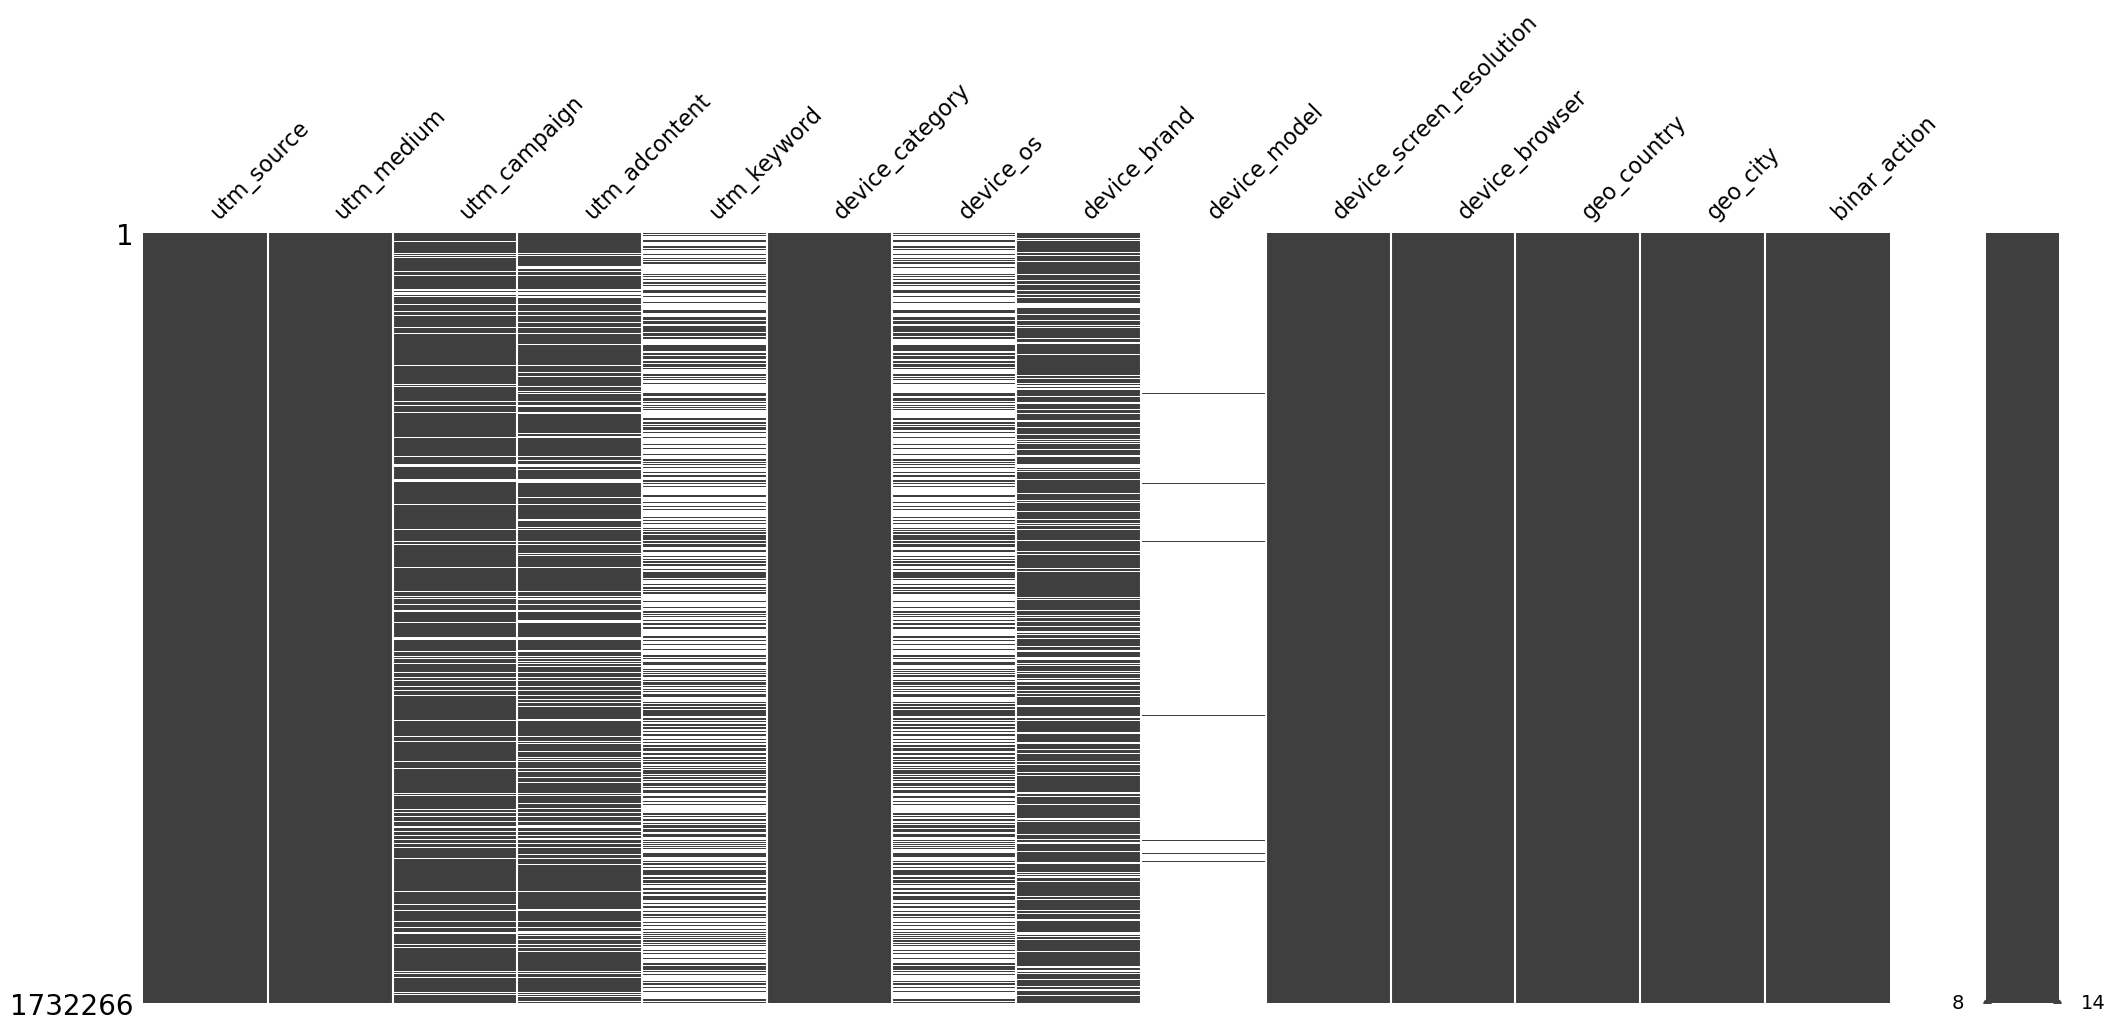

In [29]:
msno.matrix(df_total)

#### Удаление дубликатов

In [30]:
df_total.duplicated().sum()

1319574

In [31]:
df_total_dd = df_total[~df_total.duplicated()]
df_total_dd

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,binar_action
0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0
1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0
2,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0
3,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0
4,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732257,bByPQxmDaMXgpHeypKSM,referral,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Samsung,NaN,360x800,Android Webview,Russia,Saint Petersburg,1
1732258,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Samsung,NaN,384x854,Chrome,Russia,Birsk,0
1732259,ISrKoXQCxqqYvAZICvjs,blogger_stories,zfwIehuEfWYdYrEZgRLo,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,NaN,414x896,Safari,Russia,Zheleznodorozhny,0
1732260,kjsLglQLzykiRbcDiGcD,cpc,vXsFkagGabkcWKlgLzSg,NaN,NaN,mobile,NaN,Samsung,NaN,320x676,Chrome,Russia,Naro-Fominsk,0


In [32]:
df_total_dd.reset_index(drop=True , inplace=True)

#### Пропуски после удаления дубликатов

In [33]:
df_total_dd.isna().sum() / len(df_total_dd) * 100

utm_source                   0.009450
utm_medium                   0.000000
utm_campaign                10.787706
utm_adcontent               19.093174
utm_keyword                 51.017466
device_category              0.000000
device_os                   50.440765
device_brand                21.808273
device_model                97.698041
device_screen_resolution     0.000000
device_browser               0.000000
geo_country                  0.000000
geo_city                     0.000000
binar_action                 0.000000
dtype: float64

#### Дисбаланс классов целевого признака

In [34]:
df_total_dd['binar_action'].value_counts(normalize=True)

binar_action
0    0.940777
1    0.059223
Name: proportion, dtype: float64

In [35]:
df_total_dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412692 entries, 0 to 412691
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   utm_source                412653 non-null  object
 1   utm_medium                412692 non-null  object
 2   utm_campaign              368172 non-null  object
 3   utm_adcontent             333896 non-null  object
 4   utm_keyword               202147 non-null  object
 5   device_category           412692 non-null  object
 6   device_os                 204527 non-null  object
 7   device_brand              322691 non-null  object
 8   device_model              9500 non-null    object
 9   device_screen_resolution  412692 non-null  object
 10  device_browser            412692 non-null  object
 11  geo_country               412692 non-null  object
 12  geo_city                  412692 non-null  object
 13  binar_action              412692 non-null  int32 
dtypes: i

#### Удаление, заполнение пропусков

In [36]:
df_new = df_total_dd.copy()
df_new.drop(columns = ['utm_keyword', 'device_os', 'device_model'], inplace = True)
df_new.columns

Index(['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'device_category', 'device_brand', 'device_screen_resolution',
       'device_browser', 'geo_country', 'geo_city', 'binar_action'],
      dtype='object')

In [37]:
df_new.fillna({'utm_campaign' : 'other', 'utm_adcontent' : 'other', 'device_brand' : 'other'}, inplace = True)
df_new.isna().sum() / len(df_new) * 100

utm_source                  0.00945
utm_medium                  0.00000
utm_campaign                0.00000
utm_adcontent               0.00000
device_category             0.00000
device_brand                0.00000
device_screen_resolution    0.00000
device_browser              0.00000
geo_country                 0.00000
geo_city                    0.00000
binar_action                0.00000
dtype: float64

In [38]:
pd.concat([df_new.utm_source.value_counts(normalize=True, dropna=False).sort_values(ascending=False) * 100, 
           df_new.loc[:,['utm_source', 'binar_action']].groupby('utm_source', dropna=False).mean()], axis=1)

,proportion,binar_action
utm_source,,
ZpYIoDJMcFzVoPFsHGJL,22.960707,0.075551
kjsLglQLzykiRbcDiGcD,16.760926,0.048098
MvfHsxITijuriZxsqZqt,12.221705,0.030870
fDLlAcSmythWSCVMvqvL,9.994621,0.090576
bByPQxmDaMXgpHeypKSM,8.174377,0.087891
...,...,...
eFGuYtbktaqRjJGmKrgt,0.000242,0.000000
oetAUjPZXdyoRrCakDpG,0.000242,0.000000
jCIRaffxlokbeWIRXHKg,0.000242,0.000000


Если бы баланс классов в utm_source NaN был не 10%, а ~6% как по датасету, тогда удалил бы строки. Мода составляет 23% - мало для того чтобы ей заполнять.
Приедется тоже заполнить Other

In [39]:
df_new.fillna({'utm_source' : 'other'}, inplace = True)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412692 entries, 0 to 412691
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   utm_source                412692 non-null  object
 1   utm_medium                412692 non-null  object
 2   utm_campaign              412692 non-null  object
 3   utm_adcontent             412692 non-null  object
 4   device_category           412692 non-null  object
 5   device_brand              412692 non-null  object
 6   device_screen_resolution  412692 non-null  object
 7   device_browser            412692 non-null  object
 8   geo_country               412692 non-null  object
 9   geo_city                  412692 non-null  object
 10  binar_action              412692 non-null  int32 
dtypes: int32(1), object(10)
memory usage: 33.1+ MB


### Feature engineering

#### Подготовим типы данных для API

In [40]:
types = {
    'int64': 'int',
    'float64': 'float'
}
for k, v in df_new.dtypes.items():
    print(f'{k}: {types.get(str(v), "str")}')

utm_source: str
utm_medium: str
utm_campaign: str
utm_adcontent: str
device_category: str
device_brand: str
device_screen_resolution: str
device_browser: str
geo_country: str
geo_city: str
binar_action: str


#### Делим на X Y 

In [41]:
X = df_new.drop('binar_action', axis=1).copy()
Y = df_new.binar_action.copy()

#### OHE

In [39]:
X.columns

Index(['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'device_category', 'device_brand', 'device_screen_resolution',
       'device_browser', 'geo_country', 'geo_city'],
      dtype='object')

In [40]:
# columns_to_encode = ['utm_source', 'utm_medium', 'utm_campaign', 
#                      'utm_adcontent', 'device_category', 'device_brand', 
#                      'device_screen_resolution', 'device_browser', 
#                      'geo_country', 'geo_city']

# encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# encoder.fit(X[columns_to_encode])

# X.loc[:, encoder.get_feature_names_out()] = encoder.transform(X[columns_to_encode])
# X.head()

In [41]:
# X.shape

Многовато признаков. Если обучение пойдет плохо, попробую LabelEncoder или HashingEncoder

In [42]:
#  columns_to_drop = ['utm_source', 'utm_medium', 'utm_campaign', 
#                      'utm_adcontent', 'device_category', 'device_brand', 
#                      'device_screen_resolution', 'device_browser', 
#                      'geo_country', 'geo_city']

# X.drop(columns_to_drop, axis=1, inplace=True)

In [43]:
# X.info()

Нет, обучаться на 27 Гб да еще и с кросс-валидачией, мой комп умрет на наделю минимум.

Так же наблюдается проблема с индексами, `Index: 412692 entries, 0 to 1732261` , подправим.

#### OHE - HashingEncoder

In [44]:
columns_to_encode = ['utm_source', 'utm_medium', 'utm_campaign', 
                      'utm_adcontent', 'device_category', 'device_brand', 
                      'device_screen_resolution', 'device_browser', 
                      'geo_country', 'geo_city']

In [46]:
encoder_purpose = ce.HashingEncoder(n_components=8, cols=columns_to_encode)
encoder_purpose.fit_transform(X)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7
0,2,1,2,1,2,1,0,1
1,4,3,0,0,3,0,0,0
2,1,1,3,1,2,1,0,1
3,3,2,0,0,2,1,0,2
4,3,2,0,0,1,1,0,3
...,...,...,...,...,...,...,...,...
1732257,3,3,0,2,2,0,0,0
1732258,1,3,2,1,3,0,0,0
1732259,2,1,2,2,1,1,0,1
1732260,1,2,1,1,1,1,1,2


In [47]:
X_encoded = encoder_purpose.fit_transform(X)

In [49]:
X.describe()

,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
count,412692,412692,412692,412692,412692,412692,412692,412692,412692,412692
unique,281,55,407,281,3,201,4947,55,159,2389
top,ZpYIoDJMcFzVoPFsHGJL,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,other,360x640,Chrome,Russia,Moscow
freq,94757,120077,82693,213669,312362,90001,21155,234581,380561,89335


### Modeling HashOHE

Вспоминаем что у нас проблемы с индексами и балансом классов

In [53]:
X_encoded.reset_index(drop=True , inplace=True)
Y.reset_index(drop=True , inplace=True)

In [56]:
models = [
    LogisticRegression(solver='saga', class_weight='balanced', n_jobs=-1),
    RandomForestClassifier(class_weight='balanced', n_jobs=-1),
    MLPClassifier()
]

for m in models:
    score = cross_val_score(m, X_encoded, Y, cv=4, scoring='roc_auc', n_jobs=-1)
    print(f'model: {type(m).__name__}, ra_mean: {score.mean():.4f}, ra_std: {score.std():.4f}')

model: LogisticRegression, ra_mean: 0.5698, ra_std: 0.0041
model: RandomForestClassifier, ra_mean: 0.6097, ra_std: 0.0049
model: MLPClassifier, ra_mean: 0.6185, ra_std: 0.0058


In [64]:
 param_grid = {
   'activation': ['identity', 'logistic', 'tanh', 'relu'],
   'solver': ['lbfgs', 'sgd', 'adam'],
   'max_iter': [500]
}

In [65]:
mlp = MLPClassifier(random_state=42)

In [66]:
 grid_search_mlp = GridSearchCV(
   estimator=mlp,
   param_grid=param_grid,
   scoring='roc_auc',
   verbose=1,
   n_jobs=-1
)

In [67]:
 grid_search_mlp.fit(X_encoded, Y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=MLPClassifier(random_state=42), n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'max_iter': [500],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             scoring='roc_auc', verbose=1)

In [68]:
 grid_search_mlp.best_params_

{'activation': 'tanh', 'max_iter': 500, 'solver': 'lbfgs'}

In [70]:
grid_search_mlp.best_score_

0.6198748458374881

#### OHE v2

In [72]:
encoder_purpose = ce.HashingEncoder(n_components=16, cols=columns_to_encode)
X_encoded_2 = encoder_purpose.fit_transform(X)
X_encoded_2

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15
0,1,0,0,1,2,1,0,1,1,1,2,0,0,0,0,0
1,2,0,0,0,1,0,0,0,2,3,0,0,2,0,0,0
2,1,0,1,1,2,1,0,1,0,1,2,0,0,0,0,0
3,1,1,0,0,1,1,0,0,2,1,0,0,1,0,0,2
4,1,1,0,0,1,1,0,0,2,1,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732257,2,0,0,2,0,0,0,0,1,3,0,0,2,0,0,0
1732258,1,1,0,1,2,0,0,0,0,2,2,0,1,0,0,0
1732259,2,0,1,1,0,0,0,0,0,1,1,1,1,1,0,1
1732260,1,0,1,1,1,1,0,0,0,2,0,0,0,0,1,2


In [74]:
models = [
    LogisticRegression(solver='saga', class_weight='balanced', n_jobs=-1),
    RandomForestClassifier(class_weight='balanced', n_jobs=-1),
    MLPClassifier(activation='tanh', max_iter=500, solver='lbfgs')
]

for m in models:
    score = cross_val_score(m, X_encoded_2, Y, cv=4, scoring='roc_auc', n_jobs=-1)
    print(f'model: {type(m).__name__}, ra_mean: {score.mean():.4f}, ra_std: {score.std():.4f}')

model: LogisticRegression, ra_mean: 0.6079, ra_std: 0.0039
model: RandomForestClassifier, ra_mean: 0.6136, ra_std: 0.0078
model: MLPClassifier, ra_mean: 0.6644, ra_std: 0.0063


#### Выбираем MLPClassifier, OHE - HashingEncoder. Пробуем еще увеличить roc_auc

In [75]:
encoder_purpose = ce.HashingEncoder(n_components=32, cols=columns_to_encode)
X_encoded_3 = encoder_purpose.fit_transform(X)
X_encoded_3.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31
0,0,0,0,0,1,0,0,1,1,0,...,0,0,0,1,1,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,1,...,0,0,2,2,0,0,2,0,0,0
2,0,0,0,0,1,0,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,2,1,0,0,1,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,2,1,0,0,0,0,0,1


In [78]:
mlp_model = MLPClassifier(activation='tanh', max_iter=600, solver='lbfgs', random_state=42)

In [79]:
mlp_score = cross_val_score(mpl_model, X_encoded_3, Y, cv=4, scoring='roc_auc', n_jobs=-1)
print(f'model: {type(mlp_model).__name__}, ra_mean: {mlp_score.mean():.4f}, ra_std: {mlp_score.std():.4f}')

model: MLPClassifier, ra_mean: 0.6928, ra_std: 0.0081


##### model: MLPClassifier, ra_mean: 0.6928, ra_std: 0.0081

###  Feature engineering

#### OHE - TargetEncoder

In [82]:
X.reset_index(drop=True , inplace=True)
Y.reset_index(drop=True , inplace=True)

In [83]:
encoder = ce.TargetEncoder(cols=columns_to_encode, smoothing=0, return_df=True)
X_encoded_target = encoder.fit_transform(X, Y)
X_encoded_target

,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
0,0.075551,0.073665,0.081984,0.070327,0.059601,0.058023,0.050641,0.058496,0.06142,0.022727
1,0.030870,0.028611,0.026621,0.028502,0.059601,0.065553,0.088242,0.053431,0.06142,0.077439
2,0.075551,0.073665,0.081984,0.070327,0.059601,0.058023,0.050641,0.058496,0.06142,0.066938
3,0.048098,0.043089,0.073944,0.019912,0.059601,0.055619,0.058537,0.058496,0.06142,0.077439
4,0.048098,0.043089,0.073944,0.058328,0.059601,0.055619,0.058537,0.058496,0.06142,0.077439
...,...,...,...,...,...,...,...,...,...,...
412687,0.087891,0.091509,0.094845,0.072575,0.059601,0.065553,0.069199,0.049143,0.06142,0.065413
412688,0.075551,0.073665,0.081984,0.070327,0.059601,0.065553,0.062623,0.058496,0.06142,0.059223
412689,0.032152,0.015497,0.034274,0.072575,0.059601,0.075425,0.080570,0.078822,0.06142,0.037232
412690,0.048098,0.043089,0.042925,0.058328,0.059601,0.065553,0.038789,0.058496,0.06142,0.037303


In [88]:
X_encoded_target.isna().sum() / len(X_encoded_target) * 100

utm_source                  0.000000
utm_medium                  0.000000
utm_campaign                0.009692
utm_adcontent               0.000000
device_category             0.000000
device_brand                0.000000
device_screen_resolution    0.048462
device_browser              0.004846
geo_country                 0.014539
geo_city                    0.072693
dtype: float64

Пока не разобрался в алгоритме OHE - TargetEncoder, но откуда-то взялись NaN

In [91]:
X_encoded_target = X_encoded_target.fillna(0)

In [92]:
X_encoded_target.isna().sum() / len(X_encoded_target) * 100

utm_source                  0.0
utm_medium                  0.0
utm_campaign                0.0
utm_adcontent               0.0
device_category             0.0
device_brand                0.0
device_screen_resolution    0.0
device_browser              0.0
geo_country                 0.0
geo_city                    0.0
dtype: float64

### Modeling TargetOHE

#### Select model

In [93]:
models = [
    LogisticRegression(solver='saga', class_weight='balanced', n_jobs=-1, random_state=42),
    RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42),
    MLPClassifier(activation='tanh', max_iter=600, solver='lbfgs', random_state=42)
]

for m in models:
    score = cross_val_score(m, X_encoded_target, Y, cv=4, scoring='roc_auc', n_jobs=-1)
    print(f'model: {type(m).__name__}, ra_mean: {score.mean():.4f}, ra_std: {score.std():.4f}')

model: LogisticRegression, ra_mean: 0.7310, ra_std: 0.0062
model: RandomForestClassifier, ra_mean: 0.6294, ra_std: 0.0061
model: MLPClassifier, ra_mean: 0.7298, ra_std: 0.0059


Странный результат, проверим еще раз

#### train_test_split

In [42]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, stratify=Y)

In [43]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((309519, 10), (103173, 10), (309519,), (103173,))

In [45]:
encoder = ce.TargetEncoder(cols=columns_to_encode, smoothing=0, return_df=True)

df_train_transformed = encoder.fit_transform(x_train, y_train)
df_test_transformed = encoder.transform(x_test)

In [48]:
df_train_transformed = df_train_transformed.fillna(0)
df_test_transformed = df_test_transformed.fillna(0)

In [49]:
models = [
    LogisticRegression(n_jobs=-1, random_state=42),
    RandomForestClassifier(n_jobs=-1, random_state=42),
    MLPClassifier(random_state=42)
]

for m in models:
    m.fit(df_train_transformed, y_train)
    score_train = roc_auc_score(y_train, m.predict(df_train_transformed))
    score_test = roc_auc_score(y_test, m.predict(df_test_transformed))
    print(f'model: {type(m).__name__}, ra_train: {score_train:.4f}, ra_test: {score_test:.4f}')

model: LogisticRegression, ra_train: 0.5001, ra_test: 0.5001
model: RandomForestClassifier, ra_train: 0.6857, ra_test: 0.4924
model: MLPClassifier, ra_train: 0.5000, ra_test: 0.5000


### Feature engineering

#### Замена редких значений, реже 0,05% (менее 206раз) на other

In [67]:
X.describe()

,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
count,412692,412692,412692,412692,412692,412692,412692,412692,412692,412692
unique,281,55,407,281,3,201,4947,55,159,2389
top,ZpYIoDJMcFzVoPFsHGJL,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,other,360x640,Chrome,Russia,Moscow
freq,94757,120077,82693,213669,312362,90001,21155,234581,380561,89335


In [68]:
X_short_2 = X.copy()
for col in X_short_2.columns:
    tmp_dict = dict(X_short_2[col].value_counts(normalize=True, dropna=False).sort_values(ascending=False) * 100)
    X_short_2[col] = list(map(lambda x: x if tmp_dict[x] > 0.05 else 'other', X_short_2[col]))
X_short_2.describe()

,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city
count,412692,412692,412692,412692,412692,412692,412692,412692,412692,412692
unique,49,23,116,54,3,34,130,11,33,211
top,ZpYIoDJMcFzVoPFsHGJL,cpc,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,other,other,Chrome,Russia,Moscow
freq,94757,120077,82693,213669,312362,93301,31929,234581,380561,89335


#### OHE

In [70]:
columns_to_encode = ['utm_source', 'utm_medium', 'utm_campaign', 
                     'utm_adcontent', 'device_category', 'device_brand', 
                     'device_screen_resolution', 'device_browser', 
                     'geo_country', 'geo_city']

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(X_short_2[columns_to_encode])

X_short_2.loc[:, encoder.get_feature_names_out()] = encoder.transform(X_short_2[columns_to_encode])
X_short_2.head()

,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,...,geo_city_Yegoryevsk,geo_city_Yekaterinburg,geo_city_Yerevan,geo_city_Yoshkar-Ola,geo_city_Yuzhno-Sakhalinsk,geo_city_Zagorjanskas,geo_city_Zheleznodorozhny,geo_city_Zhukovskiy,geo_city_Zvenigorod,geo_city_other
0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,other,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Samsung,385x854,Samsung Internet,Russia,Moscow,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,Krasnoyarsk,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,kjsLglQLzykiRbcDiGcD,cpc,other,other,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
columns_to_drop = ['utm_source', 'utm_medium', 'utm_campaign', 
                     'utm_adcontent', 'device_category', 'device_brand', 
                     'device_screen_resolution', 'device_browser', 
                     'geo_country', 'geo_city']

X_short_2.drop(columns_to_drop, axis=1, inplace=True)

In [78]:
X_short_2.dtypes.describe()

count         664
unique          1
top       float64
freq          664
dtype: object

#### Проверка корреляции признаков

In [105]:
corr_pivot = X_short_2.corr()
corr_pivot

,utm_source_BHcvLfOaCWvWTykYqHVe,utm_source_BKeImrJuRDZcHiSSTdzm,utm_source_DnEUulZAecfGPvdtZBYS,utm_source_FTAuYVNoYYxgvKMpKSLW,utm_source_GmILPdZyuAVJCPsUBHeN,utm_source_GpAkIXsclxDGyILfNlrR,utm_source_HFaOtpcChAlcMuxEAlpu,utm_source_ISrKoXQCxqqYvAZICvjs,utm_source_IZEXUFLARCUMynmHNBGo,utm_source_KgicpPxiEQfzPlPwQZJq,...,geo_city_Yegoryevsk,geo_city_Yekaterinburg,geo_city_Yerevan,geo_city_Yoshkar-Ola,geo_city_Yuzhno-Sakhalinsk,geo_city_Zagorjanskas,geo_city_Zheleznodorozhny,geo_city_Zhukovskiy,geo_city_Zvenigorod,geo_city_other
utm_source_BHcvLfOaCWvWTykYqHVe,1.000000,-0.008888,-0.010182,-0.006674,-0.006636,-0.016043,-0.008389,-0.024879,-0.020309,-0.011210,...,0.001454,-0.018546,0.000194,-0.004788,-0.006992,0.002078,0.009585,0.002781,0.007307,-0.030128
utm_source_BKeImrJuRDZcHiSSTdzm,-0.008888,1.000000,-0.001301,-0.000852,-0.000848,-0.002049,-0.001072,-0.003178,-0.002594,-0.001432,...,-0.001000,0.003251,-0.000996,0.000743,-0.001288,-0.000944,-0.000749,-0.000323,-0.001232,-0.004001
utm_source_DnEUulZAecfGPvdtZBYS,-0.010182,-0.001301,1.000000,-0.000977,-0.000971,-0.002348,-0.001228,-0.003641,-0.002972,-0.001640,...,-0.001145,0.006221,-0.001141,0.000313,0.000172,-0.001082,-0.002181,-0.000753,-0.001411,-0.003768
utm_source_FTAuYVNoYYxgvKMpKSLW,-0.006674,-0.000852,-0.000977,1.000000,-0.000636,-0.001539,-0.000805,-0.002386,-0.001948,-0.001075,...,-0.000751,-0.003202,-0.000748,-0.000924,-0.000967,-0.000709,-0.001964,-0.001298,-0.000925,-0.002588
utm_source_GmILPdZyuAVJCPsUBHeN,-0.006636,-0.000848,-0.000971,-0.000636,1.000000,-0.001530,-0.000800,-0.002373,-0.001937,-0.001069,...,-0.000746,-0.002409,-0.000743,-0.000919,-0.000961,-0.000705,0.000546,-0.001291,0.001720,-0.000343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
geo_city_Zagorjanskas,0.002078,-0.000944,-0.001082,-0.000709,-0.000705,-0.000277,-0.000891,0.001058,-0.002158,0.000848,...,-0.000832,-0.003547,-0.000828,-0.001024,-0.001071,1.000000,-0.002175,-0.001438,-0.001025,-0.008063
geo_city_Zheleznodorozhny,0.009585,-0.000749,-0.002181,-0.001964,0.000546,-0.002647,-0.001480,-0.001273,-0.003103,-0.001077,...,-0.002303,-0.009821,-0.002293,-0.002835,-0.002966,-0.002175,1.000000,-0.003983,-0.002838,-0.022326
geo_city_Zhukovskiy,0.002781,-0.000323,-0.000753,-0.001298,-0.001291,-0.003121,-0.001632,0.001743,-0.003951,0.000051,...,-0.001523,-0.006494,-0.001516,-0.001875,-0.001961,-0.001438,-0.003983,1.000000,-0.001876,-0.014762
geo_city_Zvenigorod,0.007307,-0.001232,-0.001411,-0.000925,0.001720,-0.002224,-0.001163,-0.002029,-0.002815,0.000010,...,-0.001085,-0.004627,-0.001080,-0.001336,-0.001398,-0.001025,-0.002838,-0.001876,1.000000,-0.010518


In [128]:
corr_df = pd.DataFrame(columns=['feature_1', 'feature_2', 'corr'])
corr_df

,feature_1,feature_2,corr


In [129]:
for i, v in enumerate(corr_pivot.columns):
    for j, v_2 in enumerate(corr_pivot.index):
        if j > i:
            if (corr_pivot.loc[v, v_2] > 0.9 or corr_pivot.loc[v, v_2] < -0.9) and v!=v_2:
                corr_df.loc[len(corr_df)] = {'feature_1': v, 'feature_2': v_2, 'corr': corr_pivot.loc[v, v_2]}
corr_df

,feature_1,feature_2,corr
0,utm_source_TxKUcPpthBDPieTGmVhx,utm_adcontent_LcGIUNPUAmXtQJaDfFBR,0.999438
1,utm_source_YlsczTIyBSwTLNtuDkCd,utm_medium_outlook,1.000000
2,utm_source_YlsczTIyBSwTLNtuDkCd,utm_campaign_PTQlxxEuqjyfVHcNKQQW,0.990930
3,utm_source_ZpYIoDJMcFzVoPFsHGJL,utm_medium_banner,0.930143
4,utm_source_fDLlAcSmythWSCVMvqvL,utm_medium_(none),1.000000
5,utm_source_faqsogjxCvbseFqupueU,utm_campaign_dZqEgyoxhtbeLFMtnnVR,0.943887
6,utm_source_fgymSoTvjKPEgaIJqsiH,utm_adcontent_yYdBRbPmBMUZHXwqGxNx,0.984691
7,utm_source_gDBGzjFKYabGgSPZvrDH,utm_adcontent_UxrnyMlRBSOhOjytXnMG,0.995858
8,utm_source_geDcueAOghDzHkGMmdOq,utm_adcontent_WYLajZgbUhGimwBKDZUH,0.994188
9,utm_source_jaSOmLICuBzCFqHfBdRg,utm_medium_email,0.999847


34 признака из 664 нам погоды не сделают, наверное. Только можно удалить 2 признака с корреляцией 1: utm_medium_outlook	и utm_medium_(none).

### Modeling

#### Model select

In [79]:
models = [
    LogisticRegression(n_jobs=-1, random_state=42),
    RandomForestClassifier(n_jobs=-1, random_state=42),
    MLPClassifier(random_state=42)
]

for m in models:
    score = cross_val_score(m, X_short_2, Y, cv=5, scoring='roc_auc', n_jobs=-1)
    print(f'model: {type(m).__name__}, ra_mean: {score.mean():.4f}, ra_std: {score.std():.4f}')

model: LogisticRegression, ra_mean: 0.7534, ra_std: 0.0148


E:\anaconda\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


model: RandomForestClassifier, ra_mean: 0.5995, ra_std: 0.0108
model: MLPClassifier, ra_mean: 0.7108, ra_std: 0.0135


#### LogisticRegression save

In [80]:
lr_model = LogisticRegression(n_jobs=-1, random_state=42)
lr_score = cross_val_score(m, X_short_2, Y, cv=4, scoring='roc_auc', n_jobs=-1)
print(f'model: {type(lr_model).__name__}, ra_mean: {lr_score.mean():.4f}, ra_std: {lr_score.std():.4f}')

model: LogisticRegression, ra_mean: 0.7047, ra_std: 0.0107


In [82]:
lr_model.fit(X_short_2, Y)

LogisticRegression(n_jobs=-1, random_state=42)

In [102]:
coefs = pd.DataFrame(zip(list(X_short_2.columns), lr_model.coef_[0]), 
                     columns=['feature', 'coef']
                    ).sort_values('coef', ascending=False)
top_20_features = coefs.head(20)
top_20_features

,feature,coef
209,utm_adcontent_PkybGvWbaqORmxjNunqZ,1.842919
140,utm_campaign_emlBaVkgLVRqbEVOSSXt,1.593148
552,geo_city_Moscow,1.572906
214,utm_adcontent_WAeycgIqKXoOMXPzDUDX,1.350539
81,utm_campaign_EiQppLFrUZrUsjXVulLg,1.312707
144,utm_campaign_gecBYcKZCPMcVYdSSzKP,1.310317
92,utm_campaign_LEoPHuyFvzoNfnzGgfcd,1.299267
597,geo_city_Saint Petersburg,1.288468
26,utm_source_eLzNJHzPelJpEyBwMrKo,1.256655
42,utm_source_nrKihqcWGIzDsOqljdAv,1.164213


In [131]:
with open('cars_model.pkl', 'wb') as file:
    dill.dump({
        'model': lr_model,
        'metadata': {
            'name': 'Car event_action predict model',
            'author': 'Dmitriy Dmitriev',
            'version': 1,
            'date': datetime.now(),
            'type': type(lr_model).__name__,
            'roc_auc': lr_score.mean()
        },
        'top_features': top_20_features,
        'max_corr_info': corr_df
    }, file)
